**Najdi funkci $u$ na oblasti $\Omega = (0, 1) \times (0, 1)$ splňující:**
$$\begin{align*}
    -\Delta u &= f \qquad \text{na } \Omega \\
    u &= 0 \qquad \text{na } \partial\Omega
\end{align*}$$

**Přesné řešení:**\
Položme $u(x,y) = x(1-x)y(1-y)$. Snadno se ověří, že $u(x, y) = 0$ na $\partial\Omega$. Spočtěme Laplacián:
$$\begin{equation*}
    \Delta u = 2(x^2 + y^2 - x - y).
\end{equation*}$$
Volme funkci $f$ právě takto:
$$\begin{equation*}
    f(x, y) = -2(x^2 + y^2 - x - y).
\end{equation*}$$
Z toho je již však vidno, že dvojice $u, f$ je přesným řešením úlohy. \
Níže budeme trénovat model řešící tuto úlohu, a poté jej porovnáme s přesným řešením.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Zakladni import
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import sys

In [3]:
# Import vlastnich modulu
sys.path.append('../')
import src.models.mlp_model as mm
import src.data.cube_domain as cb
from src import train
from src import calculus as calc
from src import utils

In [4]:
# Volba vhodneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# definice funkce f(x, y)
def f(x: torch.Tensor) -> torch.Tensor:
    return -2 * (x[:, 0:1]**2 + x[:, 1:2]**2 - x[:, 0:1] - x[:, 1:2])

def exact_solution(x: torch.Tensor) -> torch.Tensor:
    return x[:, 0:1]*(1 - x[:, 0:1])*x[:, 1:2]*(1 - x[:, 1:2])

In [6]:
# Definice ztratove funkce
def loss_fn(model: nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    # ztrata na vnitrku:
    interior_input = domain.interior.requires_grad_(True)
    interior_output = model(interior_input)
    u_lapl = calc.laplacian(interior_input, interior_output, device, False)
    # print(u_lapl)
    # _, _, _, _, _, u_lapl = calc.laplacian_2d(model, domain.interior)
    # print(u_lapl)
    f_vals = f(domain.interior)
    inner_loss = torch.mean((u_lapl + f_vals) ** 2)
    
    total_bnd = torch.cat((domain.sides[0][0], domain.sides[0][1],
                           domain.sides[1][0], domain.sides[1][1]), dim=0)

    u_bnd = model(total_bnd)
    bnd_loss = torch.mean((u_bnd) ** 2)

    return [inner_loss, bnd_loss]

def solution_loss(model: nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    return calc.l2_dist_2d(model, exact_solution, domain.ctx.u_bounds, domain.ctx.l_bounds, device=domain.ctx.device)

In [7]:
# Definice domeny
config = cb.CubeContext(
    dim = 2,
    l_bounds=[0, 0],
    u_bounds=[1, 1],
    N_int=2_000,
    N_sides=[(100, 100), (100, 100)],
    device=device
)

model_ctx = mm.ModelContext(
    input_dim=2,
    output_dim=1,
    layer=[64, 64, 64],
    u_bounds=[1, 1],
    l_bounds=[0, 0],
    last_layer_activation='sinn')

domain = cb.CubeDomain(config)
# Definice modelu
model = mm.MLPModel(model_ctx).to(device)
# Definice optimizeru
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Definice scheduleru
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=500)
domain.generate_points()

In [8]:
# Spusteni trenovani
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    scheduler=scheduler,
    epochs=2_000,
    monitor_lr=True
)

loss_values = train.train_switch_to_lbfgs(ctx=context, lbfgs_lr=0.1)

Loss at epoch 1 is: 0.41771256923675537. Current learing rate: 0.001 
Loss at epoch 100 is: 0.0016393307596445084. Current learing rate: 0.001 
Loss at epoch 200 is: 0.000808682176284492. Current learing rate: 0.001 
Loss at epoch 300 is: 0.0005926283774897456. Current learing rate: 0.001 
Loss at epoch 400 is: 0.0005927898455411196. Current learing rate: 0.001 
Loss at epoch 500 is: 0.0004899485502392054. Current learing rate: 0.001 
Loss at epoch 600 is: 0.000430868734838441. Current learing rate: 0.001 
Loss at epoch 700 is: 0.0004205738950986415. Current learing rate: 0.001 
Loss at epoch 800 is: 0.00034820224391296506. Current learing rate: 0.001 
Loss at epoch 900 is: 0.00031111700809560716. Current learing rate: 0.001 
Loss at epoch 1000 is: 0.00026989245088770986. Current learing rate: 0.001 
Loss at epoch 1100 is: 0.0006037087878212333. Current learing rate: 0.001 
Loss at epoch 1200 is: 0.00023987065651454031. Current learing rate: 0.001 
Loss at epoch 1300 is: 0.000237029802

In [ ]:
# Vykresleni ztraty
plot_ctx = utils.PlotContext(
    u_bounds=domain.ctx.u_bounds,
    l_bounds=domain.ctx.l_bounds,
    device=device,
    patches=[],
    figsize=(5, 4),
    vmin=0.0,
    vmax=0.06,
    N=100,
    titles=["Loss values"],
    x_label='Epochs',
    y_label='Loss',
    function_names=['u']
)

utils.plot_loss_values({"Total loss": loss_values[0]}, plot_ctx=plot_ctx)

TypeError: PlotContext.__init__() got an unexpected keyword argument 'title'

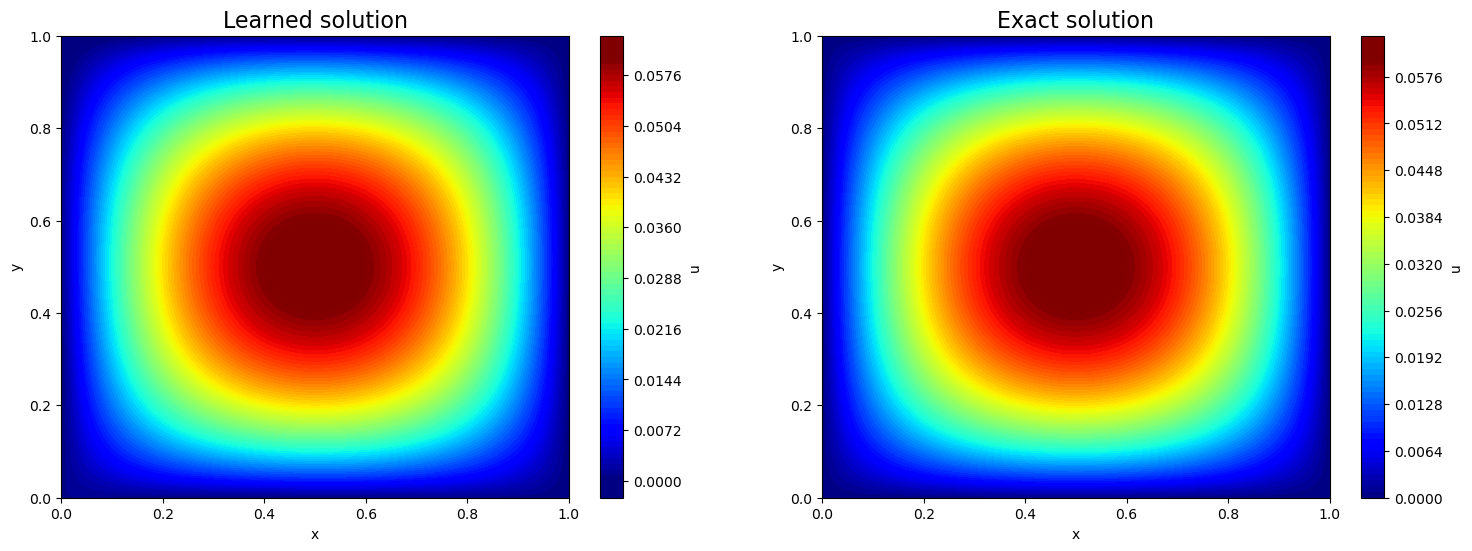

In [ ]:
# Kontrola vysledku
# prvne vykreslime trenovaci ztratu
plot_ctx.figsize = (18, 6)
plot_ctx.x_label = "x"
plot_ctx.y_label = "y"
plot_ctx.vmax = 0.06
plot_ctx.fontsize = 16
plot_ctx.titles = ["Learned solution", "Exact solution"]
plot_ctx.function_names = ['u', 'u']

utils.plot_function_on_2d_cube([model, exact_solution], plot_ctx)

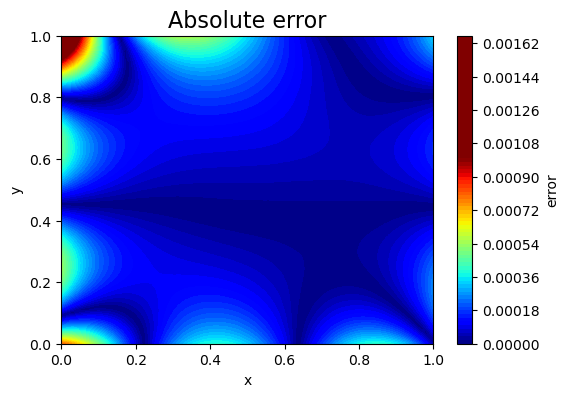

In [ ]:
# Nyni vykreslime spravne reseseni
plot_ctx.figsize = (6, 4)
plot_ctx.vmax = 0.00001
plot_ctx.titles = ["Absolute error"]
plot_ctx.function_names = ['error']

utils.plot_function_on_2d_cube([lambda x: torch.abs(model(x) - exact_solution(x))], plot_ctx)

In [ ]:
# a spocteme l2 normu rozdilu odhadu a skutecneho reseni
norm = calc.L2_norm(model, exact_solution, 2, [0, 0], [1, 1], device, n=100)
print(f"L2 norma je: {norm}")

L2 norma je: 0.00016907368262764066
